In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def test_stationarity(df, win=168):
        
    #Determing rolling statistics
    rolmean = df.rolling(window=win).mean()
    rol_wm = df.ewm(halflife=win).mean()
    rolstd = df.rolling(window=win).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    mean_w = plt.plot(rol_wm, color='green', label='Rolling Weighted Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC', maxlag=win)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

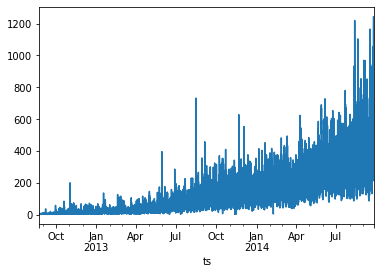

In [2]:
df = pd.read_csv(r'data/Train.csv')
df['ts'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')
df.index = df.ts
df.Count.plot()

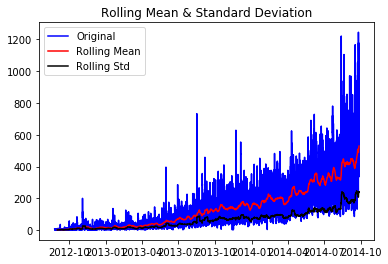

In [3]:
rol_m = df.Count.rolling(window=168).mean()
rol_std = df.Count.rolling(window=168).std()

orig = plt.plot(df.Count, color='blue',label='Original')
mean = plt.plot(rol_m, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

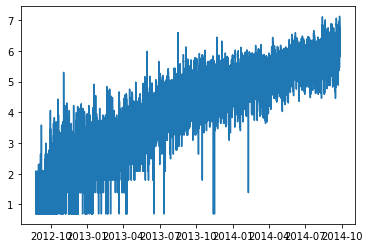

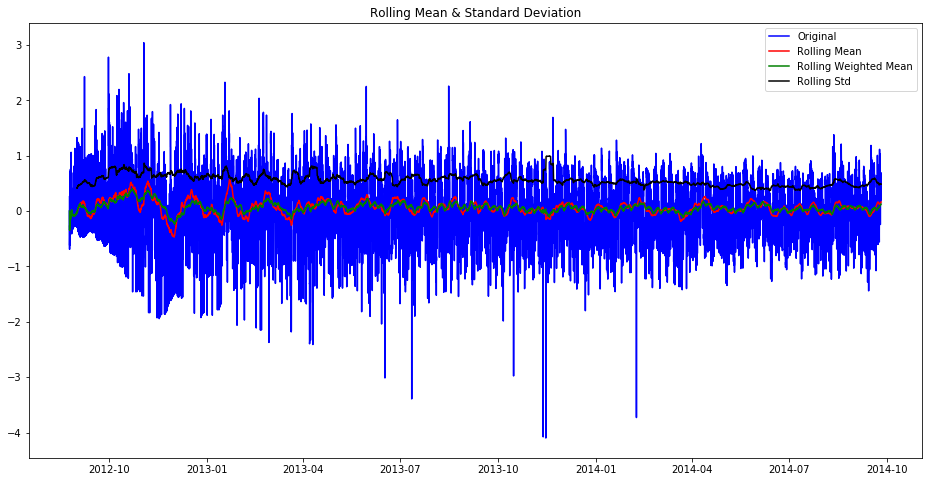

Results of Dickey-Fuller Test:
Test Statistic                -5.732481e+00
p-value                        6.551641e-07
#Lags Used                     1.680000e+02
Number of Observations Used    1.811900e+04
Critical Value (1%)           -3.430711e+00
Critical Value (5%)           -2.861700e+00
Critical Value (10%)          -2.566855e+00
dtype: float64


In [6]:
## Log transformation
count_log = np.log(df.Count)
plt.plot(count_log)

#rol_m = count.rolling(window=168).mean()
rol_wm = count_log.ewm(halflife=168).mean()
#rol_std = count.rolling(window=168).std()

#count, transformed, moving average, diff
count_tr_ma_d = count_log - rol_wm
#need to drop first 22 examples as they are nans
count_tr_ma_d.dropna(inplace=True)
test_stationarity(count_tr_ma_d)

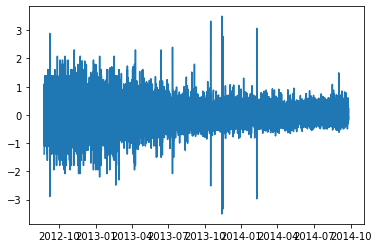

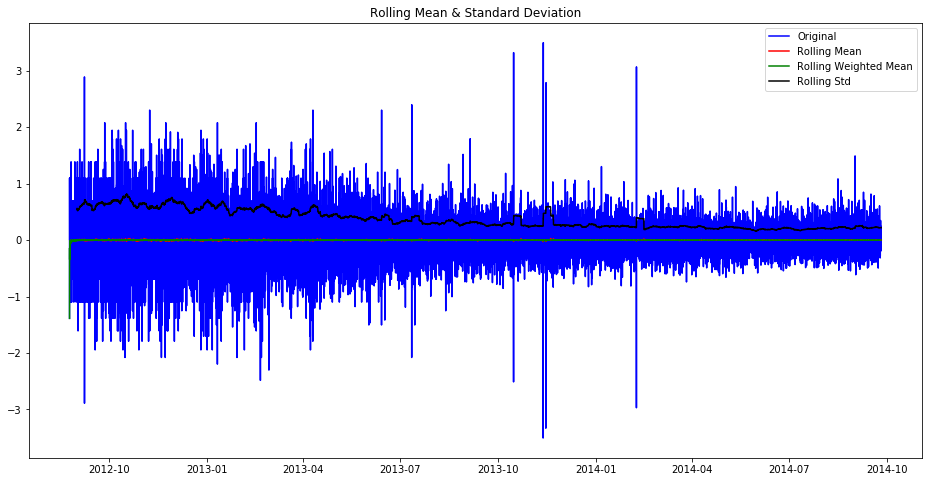

Results of Dickey-Fuller Test:
Test Statistic                   -25.440805
p-value                            0.000000
#Lags Used                       168.000000
Number of Observations Used    18118.000000
Critical Value (1%)               -3.430711
Critical Value (5%)               -2.861700
Critical Value (10%)              -2.566855
dtype: float64


In [7]:
###Differencing
count_t_diff = count_log - count_log.shift()
plt.plot(count_t_diff)
count_t_diff.dropna(inplace=True)

test_stationarity(count_t_diff)

C:\Anaconda\envs\py3-TF2.0\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


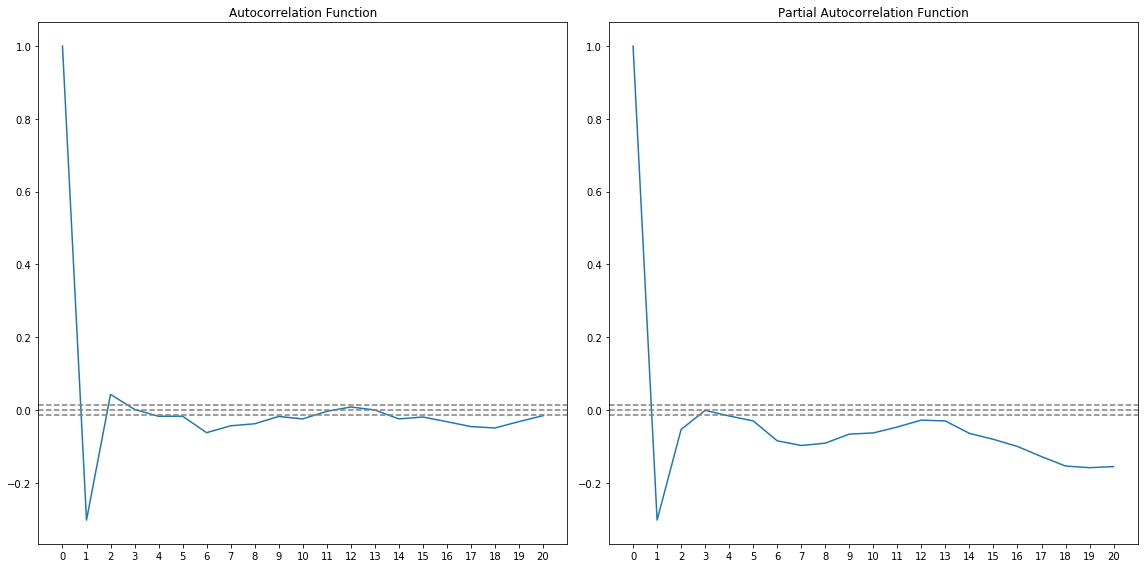

In [8]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(count_t_diff, nlags=20)
lag_pacf = pacf(count_t_diff, nlags=20, method='ols')
#Plot ACF: 
plt.figure(figsize=(16,8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.xticks(ticks=list(range(0,21,1)))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(count_t_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(count_t_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.xticks(ticks=list(range(0,21,1)))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(count_t_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(count_t_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
#gets us arima with (1,1,1) order

In [14]:
## Closure
#Arima wasnt good enough and sarimax with m = 168 (1 week) is too much for my PC. So i decided to go with Holt-Winters Method
#from stastmodels (ExponentioalSmoothing)